In [59]:
import pandas as pd 
import geopandas as gpd 
from shapely import wkt
import matplotlib.pyplot as plt
import osmnx as ox 

In [63]:
plt.rc('text', usetex=False)

In [2]:
flooding_311 = pd.read_csv('/share/ju/urbanECG/data/coords/sep29_flooding.csv')

In [6]:
flooding_311 = gpd.GeoDataFrame(flooding_311, geometry=flooding_311['geometry'].apply(wkt.loads))


In [31]:
flooding_311.crs = {'init': 'epsg:2263'}

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

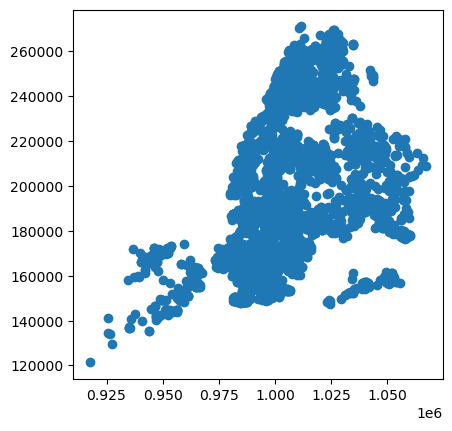

In [7]:
flooding_311.plot()

In [8]:
agreed_images = pd.read_json("/share/ju/urbanECG/output/street_flooding/agreement_sample.json")

In [11]:
agreed_images = gpd.GeoDataFrame(agreed_images, geometry=gpd.points_from_xy(agreed_images['gps_info.longitude'], agreed_images['gps_info.latitude']), crs='EPSG:4326')

In [12]:
agreed_images = agreed_images.to_crs('EPSG:2263')

<Axes: >

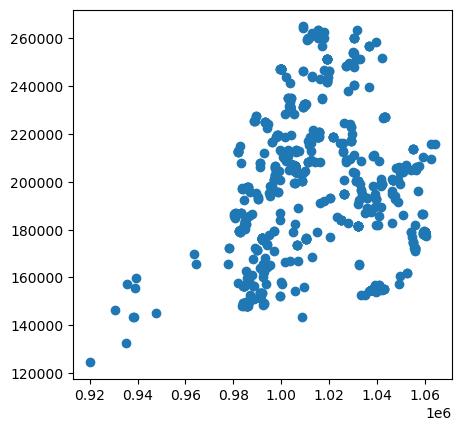

In [13]:
agreed_images.plot()

In [34]:
len(agreed_images.index)

688

In [18]:
roads = ox.io.load_graphml('../data/geo/nyc.graphml')

In [19]:
roads = ox.graph_to_gdfs(roads, nodes=False, edges=True)

In [20]:
roads = roads.to_crs('EPSG:2263')

In [26]:
nybb = gpd.read_file(gpd.datasets.get_path('nybb'))
nybb = nybb.to_crs('EPSG:2263')

/tmp/ipykernel_1516253/3010864034.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'nybb' data from the geodatasets package.

from geodatasets import get_path
path_to_file = get_path('nybb')

  nybb = gpd.read_file(gpd.datasets.get_path('nybb'))


In [47]:
# identify agreed images that are further than 100 feet from a 311 flooding report
imgs_dist = gpd.sjoin_nearest(agreed_images, flooding_311, distance_col='dist', how='left')

# groupby image id and get the minimum distance to a flooding report
imgs_dist = imgs_dist.groupby('frame_id').agg({'dist': 'min'})


In [48]:
imgs_dist

,dist
frame_id,
002ff9a45ae99b082088c482460d49ee,66.409756
0031a4713d6ed1063d8967c61df341fe,147.798576
0044877308e74a0411e08f28dbf37950,1108.350895
007d03f87b13d895fc59fa762b3aaafe,856.041668
00912b78ade6a170b24606f87b8a34b5,614.751066
...,...
febb572f1db2dc36349d67f682d7da73,2028.034736
fefcf1ae249820b17ea9c1e7687fef89,2056.068098
fefe86c8cad1909a7cf0bf04683be52f,616.942528


In [49]:
imgs_dist['far'] = imgs_dist['dist'] > 100

In [50]:
# merge images with the distance to a flooding report
agreed_images = agreed_images.merge(imgs_dist, left_on='frame_id', right_index=True)

In [51]:
agreed_images.far.describe()

count      688
unique       2
top       True
freq       635
Name: far, dtype: object

,camera_heading,timezone_offset,h3_index_res12,frame_quality,gps_info.longitude,gps_info.latitude,osm_info.osm_node_id_from,osm_info.osm_node_id_to,h3_index_res06,id,...,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts,dist
count,756.000000,756.0,7.560000e+02,756.000000,756.000000,756.000000,7.560000e+02,7.560000e+02,7.560000e+02,756.000000,...,0.0,0.0,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,188.687121,-14400.0,6.312439e+17,0.774164,-73.900306,40.709433,4.212127e+09,4.081192e+09,6.042223e+17,340.226190,...,NaN,NaN,40.709762,-73.900486,16385.632275,37.764550,3.025132,28.904762,48.265873,1052.748006
std,106.245047,0.0,1.253760e+10,0.085770,0.086814,0.084678,3.773380e+09,3.861740e+09,1.253912e+10,199.394993,...,NaN,NaN,0.084501,0.086627,4205.136902,20.078986,0.985002,14.391827,19.172882,1023.525725
min,0.000000,-14400.0,6.312439e+17,0.600241,-74.230251,40.508272,4.242259e+07,3.907650e+07,6.042223e+17,0.000000,...,NaN,NaN,40.499625,-74.239855,10090.000000,1.000000,1.000000,1.000000,2.000000,1.470061
25%,92.750000,-14400.0,6.312439e+17,0.712497,-73.970082,40.650227,2.761721e+08,4.290499e+07,6.042223e+17,169.750000,...,NaN,NaN,40.650846,-73.970598,13095.750000,21.000000,2.000000,17.000000,35.000000,359.275198
50%,188.750000,-14400.0,6.312439e+17,0.774612,-73.920201,40.713938,3.789751e+09,3.564409e+09,6.042223e+17,333.500000,...,NaN,NaN,40.713289,-73.920965,14787.000000,41.000000,3.000000,33.000000,53.500000,827.104189
75%,275.275172,-14400.0,6.312439e+17,0.834486,-73.832849,40.767077,7.898998e+09,7.967531e+09,6.042224e+17,513.250000,...,NaN,NaN,40.766939,-73.833155,18183.000000,53.000000,3.000000,41.000000,65.000000,1358.164481
max,359.750000,-14400.0,6.312440e+17,1.000000,-73.710919,40.894074,1.029410e+10,1.030919e+10,6.042224e+17,687.000000,...,NaN,NaN,40.890017,-73.707648,24671.000000,71.000000,5.000000,51.000000,77.000000,9711.124080


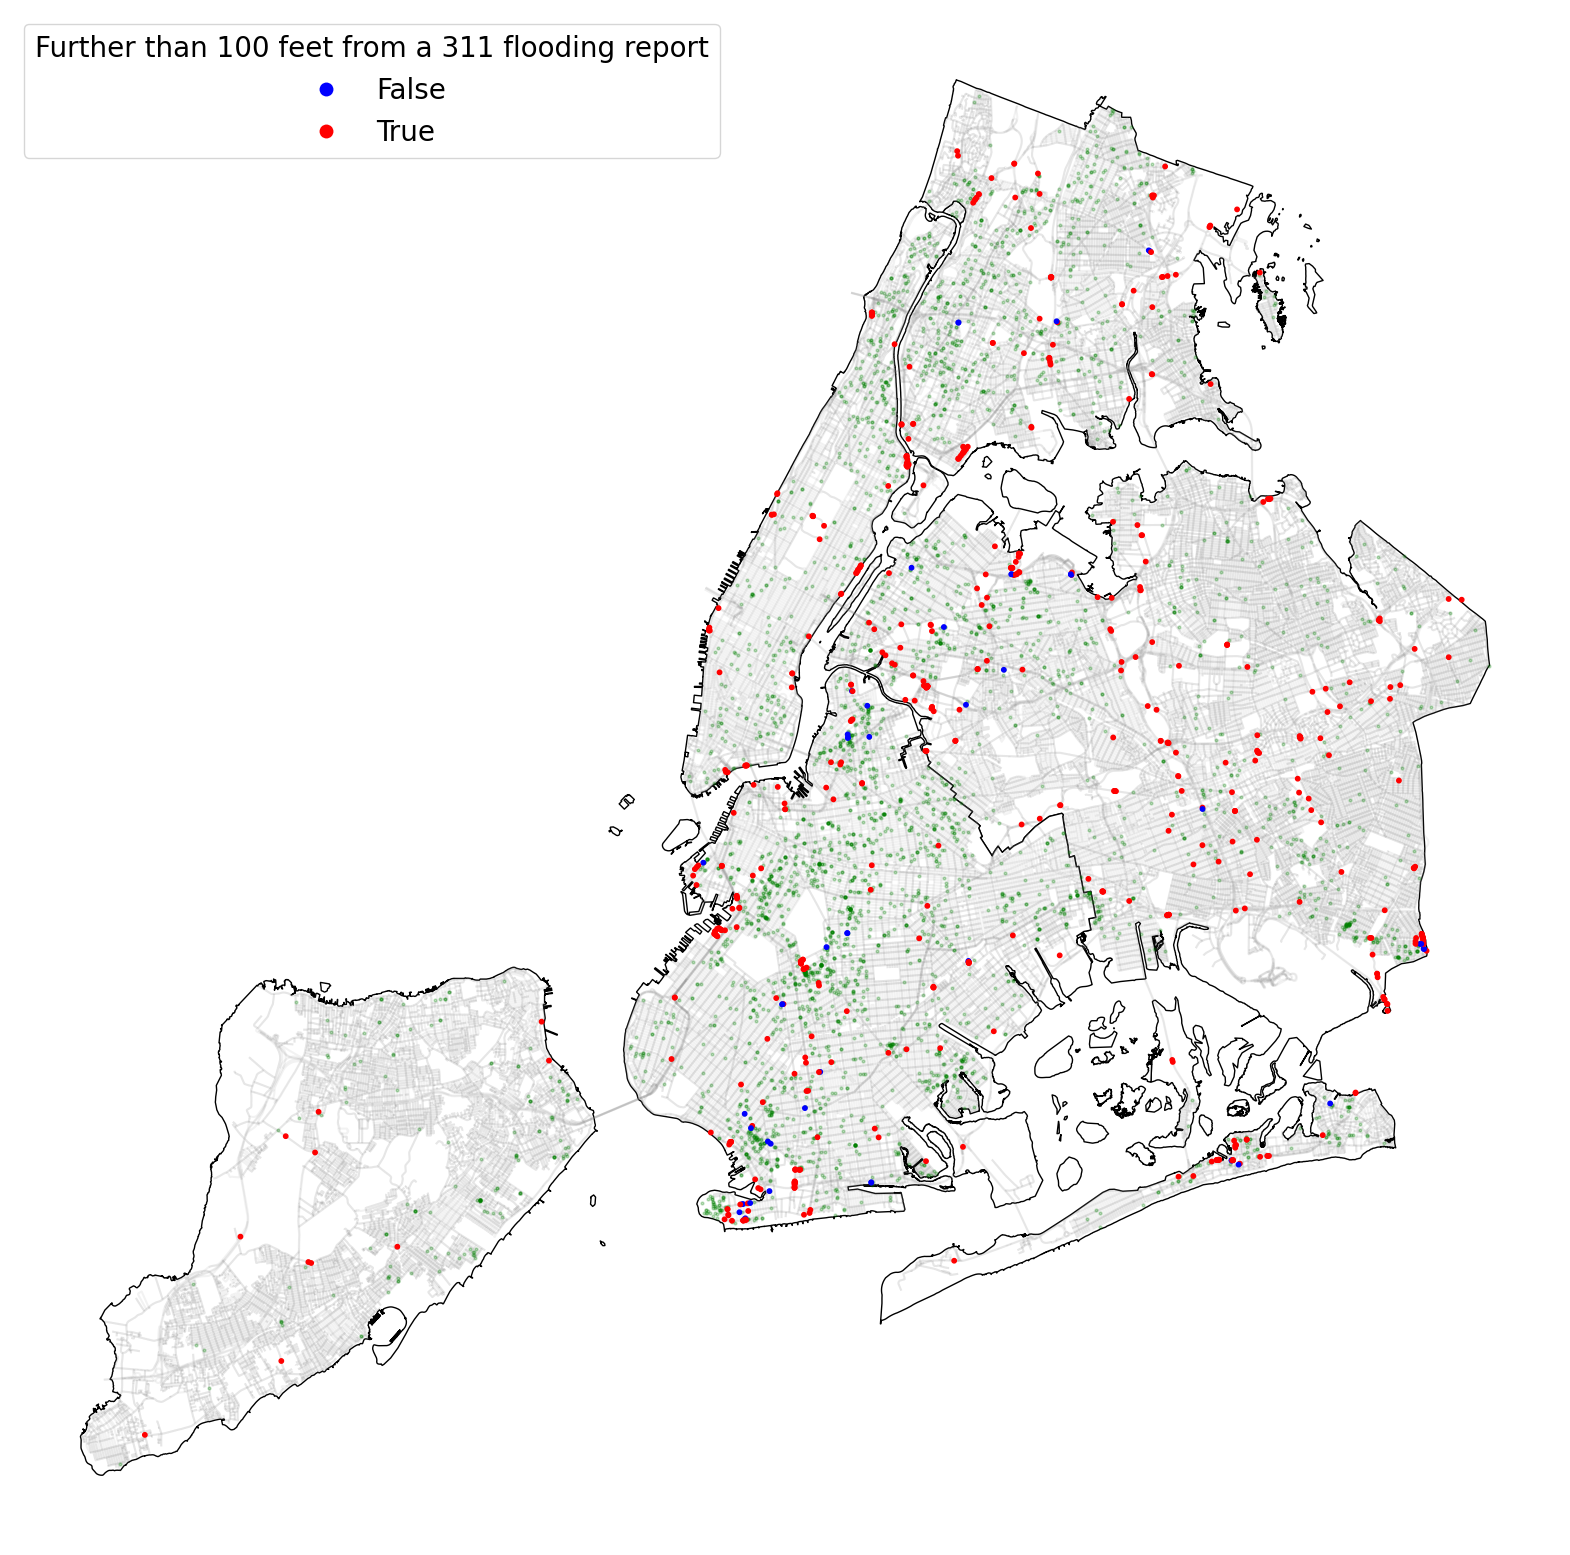

In [82]:

fig, ax = plt.subplots(figsize=(20,20))
nybb.plot(ax=ax, color='white', edgecolor='black', zorder=0)
roads.plot(ax=ax, color='gray', alpha=0.1, zorder=1)
flooding_311.plot(ax=ax, color='green', alpha=0.25, markersize=4)
agreed_images.plot(ax=ax, cmap='bwr', alpha=1, markersize=10, column='far', legend=True, zorder=2, 
                   legend_kwds={'title': "Further than 100 feet from a 311 flooding report", 'loc': 'upper left', 'fontsize': 20, 'title_fontsize':20})

# add another legend for 311 flooding reports
#ax.scatter([], [], c='green', alpha=0.25, s=100, label='311 flooding report')
#ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper right', fontsize=20)


ax.set_axis_off()

#plt.show()

plt.savefig('/share/ju/urbanECG/output/street_flooding/plots/sep29_flooding_311_vs_agreed.png', dpi=300, bbox_inches='tight')